# Linear Regression Consulting Project

### Maria Ines Montenegro
#### 07 octubre 2018

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

### Initialize spark and import libraries

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('data').getOrCreate()

In [112]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

In [118]:
df = spark.read.format("libsvm").csv("cruise_ship_info.csv", inferSchema = True, header=True)

In [119]:
df.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [120]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



First, we transform cruise line column into numerical information.

In [124]:
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_index")
indexed = indexer.fit(df).transform(df)
indexed.show()
df = indexed

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|         1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|         1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|         1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|         1.0|
|    Elati

### Drop categorical columns for the linear regression. On the first model, I include all the numerical values

In [125]:
assembler = VectorAssembler(
    inputCols = ["passengers", "Tonnage", "passenger_density", "Age", "length", "cabins", "Cruise_index"],
    outputCol = "features"
)

In [126]:
df = assembler.transform(df)

In [15]:
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[6.94,30.27699999...|
|[6.94,30.27699999...|
|[14.86,47.262,31....|
|[29.74,110.0,36.9...|
|[26.42,101.353,38...|
|[20.52,70.367,34....|
|[20.52,70.367,34....|
|[20.56,70.367,34....|
|[20.52,70.367,34....|
|[37.0,110.2389999...|
|[29.74,110.0,36.9...|
|[14.52,46.052,31....|
|[20.52,70.367,34....|
|[20.52,70.367,34....|
|[21.24,86.0,40.49...|
|[29.74,110.0,36.9...|
|[21.24,88.5,41.67...|
|[20.52,70.367,34....|
|[21.24,88.5,41.67...|
|[20.52,70.367,34....|
+--------------------+
only showing top 20 rows



In [127]:
df = df.select('crew', 'features')

In [129]:
df.show()

+----+--------------------+
|crew|            features|
+----+--------------------+
|3.55|[6.94,30.27699999...|
|3.55|[6.94,30.27699999...|
| 6.7|[14.86,47.262,31....|
|19.1|[29.74,110.0,36.9...|
|10.0|[26.42,101.353,38...|
| 9.2|[20.52,70.367,34....|
| 9.2|[20.52,70.367,34....|
| 9.2|[20.56,70.367,34....|
| 9.2|[20.52,70.367,34....|
|11.5|[37.0,110.2389999...|
|11.6|[29.74,110.0,36.9...|
| 6.6|[14.52,46.052,31....|
| 9.2|[20.52,70.367,34....|
| 9.2|[20.52,70.367,34....|
| 9.3|[21.24,86.0,40.49...|
|11.6|[29.74,110.0,36.9...|
|10.3|[21.24,88.5,41.67...|
| 9.2|[20.52,70.367,34....|
| 9.3|[21.24,88.5,41.67...|
| 9.2|[20.52,70.367,34....|
+----+--------------------+
only showing top 20 rows



In [130]:
trainData, testData = df.randomSplit([.7,.3])

In [131]:
trainData.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              116|
|   mean|7.814396551724137|
| stddev|3.440850827236245|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [132]:
testData.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|               42|
|   mean|7.738333333333333|
| stddev|3.713416621944013|
|    min|             0.59|
|    max|             19.1|
+-------+-----------------+



In [133]:
lr = LinearRegression(featuresCol='features', labelCol='crew')

In [134]:
lrModel = lr.fit(trainData)

In [135]:
print("Coefficients: {}".format(str(lrModel.coefficients)))
print('\n')
print("Intercept:{}".format(str(lrModel.intercept)))

Coefficients: [-0.1338393212986674,0.014066222496068885,-0.00205110486147369,-0.004972049727669776,0.44720684098760316,0.7683754749949162,0.04305071368481022]


Intercept:-1.2531876947053544


In [136]:
testResults = lrModel.evaluate(testData)

In [137]:
testResults.residuals.show()

+--------------------+
|           residuals|
+--------------------+
| 0.25206171691742474|
|-0.13253844817608562|
|-0.11762229899307619|
|-0.18546751162324382|
|-0.18802967655802183|
| 0.07518027518995662|
| -0.8268121538536475|
| 0.10726695679193465|
|  1.0893004507401178|
|  0.6127137639994453|
| -0.2763487526059274|
|  -1.072606277460828|
|0.013584552546784145|
| -0.6144477297964803|
|  0.9056345868745312|
| -0.2274896630201475|
|-0.34147156612048324|
|  -0.745738319799452|
|  -1.010312819332622|
| -1.0053407696049526|
+--------------------+
only showing top 20 rows



In [138]:
unlabeledData = testData.select('features')

In [139]:
predictions = lrModel.transform(unlabeledData)

In [140]:
predictions.show()

+--------------------+-------------------+
|            features|         prediction|
+--------------------+-------------------+
|[0.66,3.341,50.62...|0.33793828308257523|
|[2.08,10.0,48.08,...| 1.7325384481760857|
|[2.08,10.0,48.08,...| 1.7176222989930763|
|[2.96,16.8,56.76,...|  2.285467511623244|
|[9.52,16.852,17.7...|  3.158029676558022|
|[4.9,33.0,67.35,1...| 3.1648197248100436|
|[8.26,22.08,26.73...| 4.3268121538536475|
|[6.84,30.27699999...| 3.8927330432080653|
|[8.0,19.093,23.87...| 3.6106995492598823|
|[12.5,35.143,28.1...|  4.737286236000554|
|[12.64,55.451,43....|  5.846348752605928|
|[14.4,63.0,43.75,...|  6.682606277460828|
|[12.66,55.451,43....|  5.866415447453216|
|[14.94,53.872,36....|   6.73444772979648|
|[20.2,48.563,24.0...|  5.804365413125469|
|[15.9,69.845,43.9...| 7.1874896630201475|
|[15.66,58.6,37.42...|  7.341471566120483|
|[18.0,70.0,38.89,...|  7.945738319799452|
|[19.5,74.137,38.0...|  8.610312819332622|
|[19.5,74.137,38.0...|  8.605340769604952|
+----------

In [141]:
print("RMSE: {}".format(testResults.rootMeanSquaredError))
print("MSE: {}".format(testResults.meanSquaredError))
print("R^2 {}".format(testResults.r2))

RMSE: 1.4160631400437984
MSE: 2.0052348165907024
R^2 0.8510353172101106


As we can see in the results, the RMSE is pretty high; one must seek a lower value. On the other hand, a R^2 value close to 1 means the model is good for making predictions. Although it is high, one must first evaluate de correlation between the variables to see if there is multicollinearity.

In [172]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [173]:
names = ["passengers", "Tonnage", "passenger_density", "Age", "length", "cabins", "Cruise_line"]
data = pd.read_csv("cruise_ship_info.csv")

In [174]:
data.Cruise_line = pd.Categorical(data.Cruise_line)
data['Cruise_code'] = data.Cruise_line.cat.codes

In [175]:
y = data["crew"]
del data["crew"]
data.drop(['Ship_name','Cruise_line'], axis=1)
corr = data.corr()
corr

Age   Tonnage  passengers    length    cabins  \
Age                1.000000 -0.606646   -0.515542 -0.532286 -0.510019   
Tonnage           -0.606646  1.000000    0.945061  0.922368  0.948764   
passengers        -0.515542  0.945061    1.000000  0.883535  0.976341   
length            -0.532286  0.922368    0.883535  1.000000  0.889798   
cabins            -0.510019  0.948764    0.976341  0.889798  1.000000   
passenger_density -0.278830 -0.040846   -0.294867 -0.090488 -0.253181   
Cruise_code        0.074622 -0.118254   -0.117306 -0.217533 -0.147983   

                   passenger_density  Cruise_code  
Age                        -0.278830     0.074622  
Tonnage                    -0.040846    -0.118254  
passengers                 -0.294867    -0.117306  
length                     -0.090488    -0.217533  
cabins                     -0.253181    -0.147983  
passenger_density           1.000000     0.156049  
Cruise_code                 0.156049     1.000000

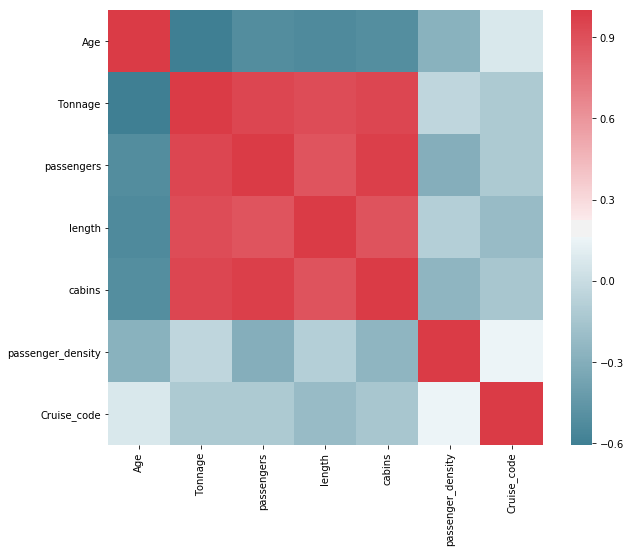

In [176]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sns.diverging_palette(220,10,as_cmap=True),square=True, ax = ax)
plt.show()

Based on this matrix, we can determine that there is quite a lot of correlation between the following variables: cabins-tonnage, passengers-cabins, passenger-length, tonnage-passengers

In [178]:
VarX = ['length', 'cabins','Age','Cruise_code']
x = data[VarX]
model = smf.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crew   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2834.
Date:                Sun, 07 Oct 2018   Prob (F-statistic):          4.80e-143
Time:                        17:43:45   Log-Likelihood:                -222.41
No. Observations:                 158   AIC:                             452.8
Df Residuals:                     154   BIC:                             465.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
length          0.3997      0.053      7.481      0.000       0.294       0.505
cabins          0.5806      0.034     16.906      0.000       0.513       0.648
Age            -0.0181      0.010     -1.771      0.079      -0.038       0.002
Cruise_code    -0.0333      0.013     -2.492      0.014      -0.060      -0.007
==============================================================================
Omnibus:                      132.374   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1954.518
Skew:                           2.926   Prob(JB):                         0.00
Kurtosis:                      19.206   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the matrix and differents tests, I decided to keep only the following columns: age, cabins and length due to their low p-value. A p-value that is lower than 0.05 indicates that the variable is significant.

In [179]:
corr2 = x.corr()
corr2

length    cabins       Age  Cruise_code
length       1.000000  0.889798 -0.532286    -0.217533
cabins       0.889798  1.000000 -0.510019    -0.147983
Age         -0.532286 -0.510019  1.000000     0.074622
Cruise_code -0.217533 -0.147983  0.074622     1.000000

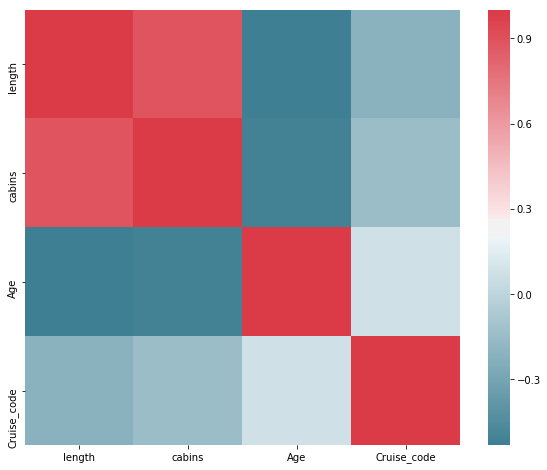

In [180]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr2,mask=np.zeros_like(corr2,dtype=np.bool),cmap=sns.diverging_palette(220,10,as_cmap=True),square=True, ax = ax)
plt.show()

The new matrix is far better because there is a good relationship between cabins-length. The other combinations don't have strong correlationship but prove to be significant to the model. Now we proceed to generate a new linear regression model with these columns.

In [181]:
df = spark.read.format("libsvm").csv("cruise_ship_info.csv", inferSchema = True, header=True)

In [182]:
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_index")
indexed = indexer.fit(df).transform(df)
indexed.show()
df = indexed

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|        16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|         1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|         1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|         1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|         1.0|
|    Elati

In [183]:
assembler = VectorAssembler(
    inputCols = ["length", "cabins", "Age","Cruise_index"],
    outputCol = "features"
)

In [184]:
output = assembler.transform(df)

In [185]:
output.select("features").show()

+--------------------+
|            features|
+--------------------+
|[5.94,3.55,6.0,16.0]|
|[5.94,3.55,6.0,16.0]|
|[7.22,7.43,26.0,1.0]|
|[9.53,14.88,11.0,...|
|[8.92,13.21,17.0,...|
|[8.55,10.2,22.0,1.0]|
|[8.55,10.2,15.0,1.0]|
|[8.55,10.22,23.0,...|
|[8.55,10.2,19.0,1.0]|
|[9.51,14.87,6.0,1.0]|
|[9.51,14.87,10.0,...|
|[7.27,7.26,28.0,1.0]|
|[8.55,10.2,18.0,1.0]|
|[8.55,10.2,17.0,1.0]|
|[9.63,10.62,11.0,...|
|[9.51,14.87,8.0,1.0]|
|[9.63,10.62,9.0,1.0]|
|[8.55,10.2,15.0,1.0]|
|[9.63,11.62,12.0,...|
|[8.55,10.2,20.0,1.0]|
+--------------------+
only showing top 20 rows



In [186]:
newData = output.select("features",'crew')

In [187]:
train_data,test_data = newData.randomSplit([0.7,0.3])

In [188]:
train_data.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              118|
|   mean|7.811525423728814|
| stddev|3.390607596790947|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [189]:
test_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|                40|
|   mean|             7.743|
| stddev|3.8626603028721824|
|    min|              0.59|
|    max|              19.1|
+-------+------------------+



In [190]:
lr = LinearRegression(featuresCol='features', labelCol='crew')

In [191]:
lrModel = lr.fit(train_data,)

In [192]:
print("Coefficients: {}".format(str(lrModel.coefficients)))
print('\n')
print("Intercept:{}".format(str(lrModel.intercept)))

Coefficients: [0.4426129024333236,0.6087873629603728,-0.012489635283257496,0.06516359036126411]


Intercept:-1.396089228348017


In [193]:
test_results = lrModel.evaluate(test_data)

In [107]:
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
| 0.24281820184336234|
| -0.4720588932329194|
| -0.4555928203098044|
| -0.1678879254306822|
|  0.9814101051772548|
|-0.34239941918074823|
|  0.2773689033969431|
|-0.19597679207871588|
| 0.30705760790240877|
|-0.44445902190503705|
|-0.03463331524098834|
| 0.14227751016656498|
|-0.27137847027513207|
| -0.6687278415479554|
|0.009111327640105138|
| -0.6922878112901243|
| -0.3054033109084511|
| 0.20065417294009436|
| -0.2947336008094288|
|  0.3289062757909651|
+--------------------+
only showing top 20 rows



In [194]:
unlabeled_data = test_data.select('features')

In [195]:
predictions = lrModel.transform(unlabeled_data)

In [196]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
| [2.8,0.33,22.0,8.0]|0.2906634749006598|
|[4.36,0.88,27.0,1...|1.3838516566310906|
|[4.4,1.04,24.0,13.0]|1.7319218277356485|
| [5.37,4.0,21.0,8.0]| 3.674917891502127|
|[5.6,2.45,14.0,10.0]|3.0508530741785442|
|[5.67,5.28,21.0,4.0]| 4.326295225376346|
|[5.78,4.25,48.0,1...| 4.388165363565836|
|[5.94,3.42,13.0,1...|3.9346820190832217|
|[5.94,3.55,6.0,16.0]| 4.361906184695929|
|[6.22,3.86,23.0,5.0]| 3.745438586105693|
|[6.7,1.82,10.0,10.0]|3.2041497693231955|
|[6.82,6.87,21.0,6.0]| 5.933599151004189|
| [6.92,8.0,23.0,0.0]|6.2498293486586425|
|[7.19,6.32,20.0,3.0]| 5.579531739475779|
|[7.27,7.26,28.0,1.0]| 5.956956629864606|
|[7.54,8.74,20.0,4.0]| 7.272875264052808|
| [7.77,7.2,13.0,3.0]| 6.459407549275036|
| [7.8,6.88,13.0,3.0]| 6.277873980200716|
|[8.24,7.83,12.0,7.0]| 7.324115648812048|
|[8.55,10.2,17.0,1.0]| 8.450721980198587|
+--------------------+------------

In [197]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R^2 {}".format(test_results.r2))

RMSE: 1.5014067533395428
MSE: 2.2542222389735866
R^2 0.8450401876923043


The R^2 has decreased, compared with the first model, which is logical due to the removal of insignificant variables that sometimes tend to add noise into the results.